# Greykite time series models

Time series models using Greykite
adapted from https://linkedin.github.io/greykite/docs/0.4.0/html/gallery/tutorials/0300_weekly_data.html

In [1]:
# Imports
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import numpy as np
np.random.seed(42)

import plotly
from greykite.framework.input.univariate_time_series import UnivariateTimeSeries
from greykite.framework.templates.autogen.forecast_config import MetadataParam
from greykite.framework.templates.autogen.forecast_config import EvaluationPeriodParam
from greykite.framework.templates.autogen.forecast_config import ModelComponentsParam
from greykite.framework.templates.autogen.forecast_config import ForecastConfig
from greykite.framework.templates.forecaster import Forecaster
from greykite.framework.utils.result_summary import summarize_grid_search_results
from collections import defaultdict

In [2]:
combined_states = pd.read_csv(f'../data/combined_states.csv', parse_dates=['week'])
combined_states_begining_covid = combined_states[combined_states['week'] < '06-2020']
combined_states_begining_covid.tail()

,week,depression,anxiety,addiction,counselling,mental_health,stay_at_home,mask_mandate,gatherings_banned,business_closures,travel_restrictions
122,2020-05-03,63.6,61.2,23.9,27.9,38.2,0.7,0.2,0.9,0.9,0.5
123,2020-05-10,62.7,64.2,23.1,27.4,35.8,0.6,0.3,0.9,0.9,0.5
124,2020-05-17,57.7,66.6,21.4,29.3,35.7,0.5,0.3,0.9,0.9,0.4
125,2020-05-24,46.1,67.2,19.3,27.1,33.5,0.4,0.3,0.8,0.8,0.3
126,2020-05-31,45.6,59.2,20.8,29.7,36.8,0.3,0.3,0.8,0.8,0.3


In [7]:
df_train = combined_states_begining_covid[:-13]
df_test = combined_states_begining_covid[-13:]

In [8]:
df_train.tail()

,week,depression,anxiety,addiction,counselling,mental_health,stay_at_home,mask_mandate,gatherings_banned,business_closures,travel_restrictions
109,2020-02-02,61.2,64.9,22.7,40.1,38.5,0.0,0.0,0.0,0.0,0.0
110,2020-02-09,58.7,67.0,18.9,37.5,38.6,0.0,0.0,0.0,0.0,0.0
111,2020-02-16,61.5,71.3,22.1,39.0,38.6,0.0,0.0,0.0,0.0,0.0
112,2020-02-23,64.6,66.7,26.2,39.9,37.7,0.0,0.0,0.0,0.0,0.0
113,2020-03-01,63.4,64.4,23.2,38.2,36.4,0.0,0.0,0.0,0.0,0.0


In [9]:
def greykite_fit_explore(data, search, autoregression=None):
    
    # Split the data to train and test
    df_train, df_test = data[0:-20], data[-20:]
    # Make timeseries data
    ts = UnivariateTimeSeries()
    ts.load_data(
    df=df_train[['week', search]],
    time_col='week',
    value_col=search,
    freq='W-SUN')
    # specify dataset information
    forecast_horizon = 13  # Forecast 13 weeks
    time_col = 'ts'  
    value_col = 'y'  
    metadata = MetadataParam(
    time_col=time_col,  
    value_col=value_col, 
    freq="W-SUN")
    
    cv_min_train_periods = 52 * 2
     # Let CV use most recent splits for cross-validation.
    cv_use_most_recent_splits = True
     # Determine the maximum number of validations.
    cv_max_splits = 6
    evaluation_period = EvaluationPeriodParam(
         test_horizon=forecast_horizon,
         cv_horizon=forecast_horizon,
         periods_between_train_test=0,
         cv_min_train_periods=cv_min_train_periods,
         cv_expanding_window=True,
         cv_use_most_recent_splits=cv_use_most_recent_splits,
         cv_periods_between_splits=None,
         cv_periods_between_train_test=0,
         cv_max_splits=cv_max_splits,
     )
    
    # Specify the model parameters
    model_components = ModelComponentsParam(
         autoregression=autoregression,
         seasonality={
             "yearly_seasonality": 25,
             "quarterly_seasonality": 0,
             "monthly_seasonality": 0,
             "weekly_seasonality": 0,
             "daily_seasonality": 0
         },
         changepoints={
             'changepoints_dict': {
                 "method": "auto",
                 "resample_freq": "7D",
                 "regularization_strength": 0.5,
                 "potential_changepoint_distance": "14D",
                 "no_changepoint_distance_from_end": "60D",
                 "yearly_seasonality_order": 25,
                 "yearly_seasonality_change_freq": None,
             },
             "seasonality_changepoints_dict": None
         },
         events={
             "holiday_lookup_countries": ["US"]
         },
         growth={
             "growth_term": None
         },
         custom={
             'feature_sets_enabled': False,
             'fit_algorithm_dict': dict(fit_algorithm='ridge')
         }
     )

    forecast_config = ForecastConfig(
         model_template = 'SILVERKITE',
         metadata_param=metadata,
         forecast_horizon=forecast_horizon,
         coverage=0.95,
         evaluation_period_param=evaluation_period,
         model_components_param=model_components
     )

     # Run the forecast model
    forecaster = Forecaster()
    result = forecaster.run_forecast_config(
         df=ts.df,
         config=forecast_config
     )
    
    get_model_results_summary(result)
    
    fig = result.backtest.plot()
    plotly.io.show(fig)
    
    fig = result.forecast.plot()
    plotly.io.show(fig)
    
    fig = result.forecast.plot_components()
    plotly.io.show(fig)
    
    return result


In [10]:
def get_model_results_summary(result):
     """Generates model results summary.

     Parameters
     ----------
     result : `ForecastResult`
         See :class:`~greykite.framework.pipeline.pipeline.ForecastResult` for documentation.

     Returns
     -------
     Prints out model coefficients, cross-validation results, overall train/test evalautions.
     """
     # Get the useful fields from the forecast result
     model = result.model[-1]
     backtest = result.backtest
     grid_search = result.grid_search

     # Check model coefficients / variables
     # Get model summary with p-values
     print(model.summary())

     # Get cross-validation results
     cv_results = summarize_grid_search_results(
         grid_search=grid_search,
         decimals=2,
         cv_report_metrics=None,
         column_order=[
             "rank", "mean_test", "split_test", "mean_train", "split_train",
             "mean_fit_time", "mean_score_time", "params"])
     # Transposes to save space in the printed output
     print("================================= CV Results ==================================")
     print(cv_results.transpose())

     # Check historical evaluation metrics (on the historical training/test set).
     backtest_eval = defaultdict(list)
     for metric, value in backtest.train_evaluation.items():
         backtest_eval[metric].append(value)
         backtest_eval[metric].append(backtest.test_evaluation[metric])
     metrics = pd.DataFrame(backtest_eval, index=["train", "test"]).T
     print("=========================== Train/Test Evaluation =============================")
     print(metrics)

Fitting 1 folds for each of 1 candidates, totalling 1 fits
================================ Model Summary =================================

Number of observations: 107,   Number of features: 92
Method: Ridge regression
Number of nonzero features: 60
Regularization parameter: 3.29

Residuals:
         Min           1Q       Median           3Q          Max
      -6.959        -2.12      -0.3018        2.129         6.79

            Pred_col Estimate Std. Err Pr(>)_boot sig. code              95%CI
           Intercept    55.11    3.363     <2e-16       ***     (49.32, 63.16)
events_Christmas Day       0.       0.      1.000                     (0., 0.)
 events_C...as Day-1       0.       0.      1.000                     (0., 0.)
 events_C...as Day-2  -0.3481   0.4959      0.306              (-1.51, 0.2017)
 events_C...as Day+1       0.       0.      1.000                     (0., 0.)
 events_C...as Day+2       0.       0.      1.000                     (0., 0.)
 events_I...ence Day  

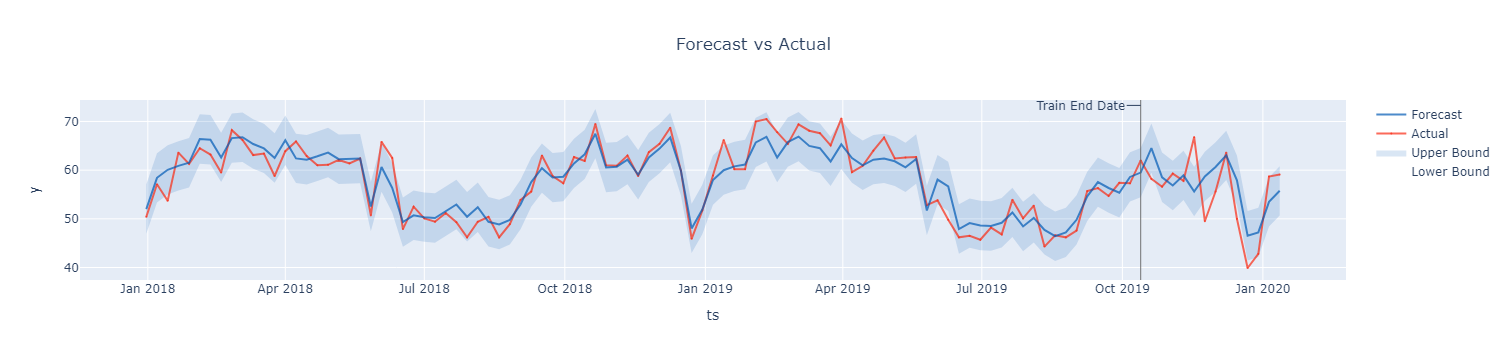

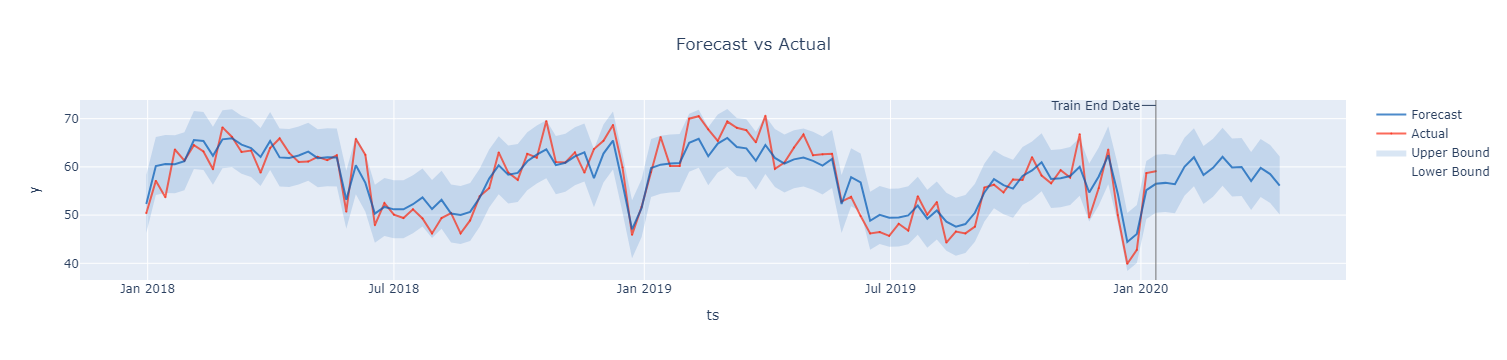

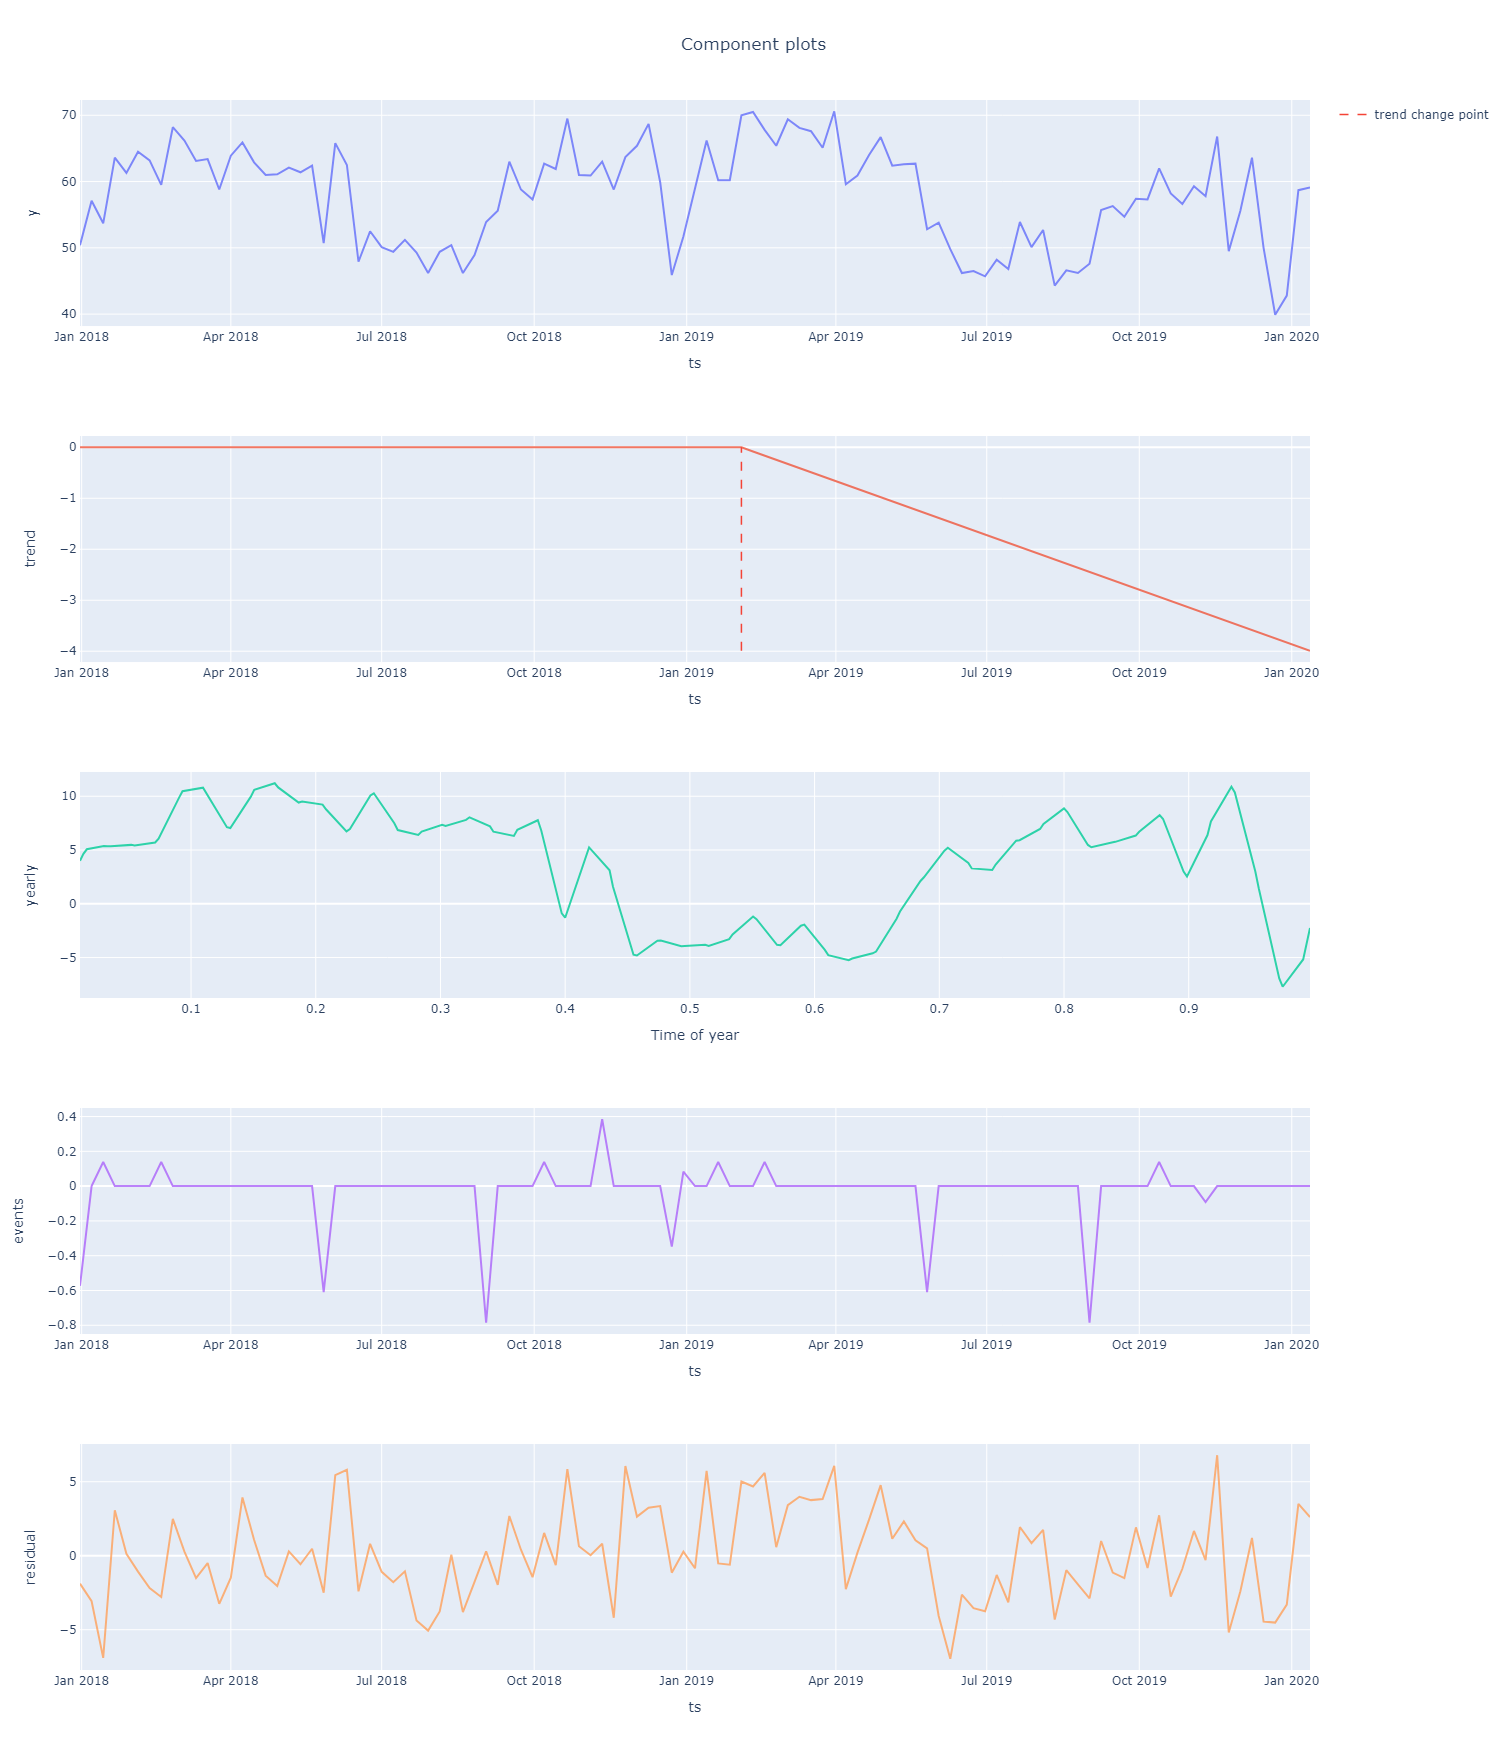

ForecastResult(timeseries=<greykite.framework.input.univariate_time_series.UnivariateTimeSeries object at 0x00000179E0EA8D88>, grid_search=RandomizedSearchCV(cv=RollingTimeSeriesSplit(expanding_window=True, forecast_horizon=13,
            max_splits=6, min_train_periods=104, periods_between_splits=13,
            periods_between_train_test=0, use_most_recent_splits=True),
                   estimator=Pipeline(steps=[('input',
                                              PandasFeatureUnion(transformer_list=[('date',
                                                                                    Pipeline(steps=[('select_date',
                                                                                                     ColumnSelector(column_names=['ts'...
                            'OutsideTolerance3p': make_scorer(score_func_finite),
                            'OutsideTolerance4p': make_scorer(score_func_finite),
                            'OutsideTolerance5p': make_scor

In [12]:
greykite_fit_explore(combined_states_begining_covid, 'depression')